# Lab ML for Data Science: Part II   
# Getting Insights into Quantum-Chemical Relations

In [237]:
import numpy as np
import pandas as pd 
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform 
from scipy.spatial import distance_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [238]:
df = scipy.io.loadmat('qm7.mat')

7165 organic molecules, each of which is composed of up to 23 atoms

In [239]:
df['R']  #3d Coordinates of each atom in each molecule

array([[[ 1.8864380e+00, -4.6487264e-03, -8.2392059e-03],
        [ 3.9499245e+00, -4.5920345e-03,  7.8234663e-03],
        [ 1.1976895e+00,  1.9404842e+00,  7.8234663e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 1.8973607e+00, -5.5746920e-03, -1.2094247e-02],
        [ 4.7544756e+00, -1.3265877e-02,  1.1149384e-03],
        [ 1.1760710e+00,  1.9320560e+00, -3.0991510e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 1.8692415e+00,  1.8897261e-04,  0.0000000e+00],
        [ 4.3934622e+00, -3.2125344e-04, -0.0000000e+00],
        [ 8.1146729e-01,  1.7577099e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0

In [240]:
df['R'].shape

(7165, 23, 3)

In [241]:
df['Z']

array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

In [242]:
df['Z'].shape # for each molecule and atom of the molecule the corresponding atomic number

(7165, 23)

Z: This is a 2D array of size 7165×23. It contains the atomic numbers for each atom in each molecule. The atomic numbers represent the type of atom:

1: Hydrogen (H)<br>
6: Carbon (C)<br>
7: Nitrogen (N)<br>
8: Oxygen (O)<br>
16: Sulfur (S)<br>
0: No atom at this position<br>

In [243]:
df['T']

array([[ -417.96,  -712.42,  -564.21, ..., -1662.1 , -1782.01, -1919.  ]],
      dtype=float32)

In [244]:
df['T'].shape

(1, 7165)

T: This is a 1D array of size 7165. It contains the atomization energies for each molecule, which have been computed via quantum-chemical simulations.

In [245]:
R = df['R']  # 3D coordinates of atoms
Z = df['Z']  # Atomic numbers , H, C, N numberings
T = df['T'].flatten()  # Atomization energies

In [246]:
Z

array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

### 1.1 Visualizing Molecules

In [247]:
atomic_symbols = {
    1: 'H',
    6: 'C',
    7: 'N',
    8: 'O',
    16: 'S'
}

In [248]:
def visualize_molecule(coordinates, atom_types, atomic_symbols, idx, threshold):
    #idx - the index of molecule
    atomic_numbers = atom_types[idx]
    coordinates = coordinates[idx]

    # Filtering out atoms that are not present (atomic number= 0)
    is_present = atomic_numbers > 0
    coordinates = coordinates[is_present]
    # Extracting xy-coordinates
    xy_coordinates = coordinates[:, :2]
    distances = distance_matrix(xy_coordinates, xy_coordinates)
    
    atomic_numbers_for_mol = atomic_numbers[is_present]
    # Mapping atomic numbers to symbols
    atomic_symbols_for_mol = [atomic_symbols[num] for num in atomic_numbers_for_mol]

    plt.figure(figsize=(15, 12))
    plt.scatter(xy_coordinates[:, 0], xy_coordinates[:, 1], c='b', marker='o')

    # Annotating points with atomic symbols for clarity
    for j, (x, y) in enumerate(xy_coordinates):
        plt.text(x, y, atomic_symbols_for_mol[j], fontsize=24, horizontalalignment='left')

    # Drawing lines between pairs of atoms in molecule having distance below the threshold
    for j in range(len(xy_coordinates)):
        for k in range(j + 1, len(xy_coordinates)):
            if distances[j, k] < threshold:
                plt.plot([xy_coordinates[j, 0], xy_coordinates[k, 0]], 
                         [xy_coordinates[j, 1], xy_coordinates[k, 1]], 
                         'r-', lw=1)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Molecule Visualization')
    plt.show()



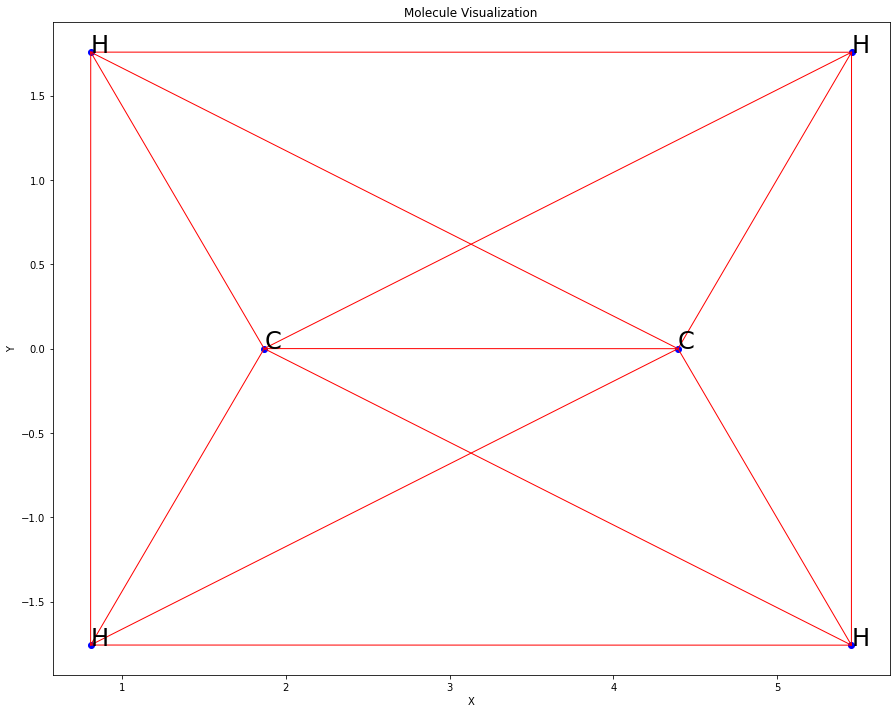

In [249]:
th=5
idx=2
visualize_molecule(R, Z, atomic_symbols, idx, th)

In [250]:
def plot_single_molecule(coordinates, atom_types, idx, threshold):
    coordinates = coordinates[idx]
    atomic_numbers = atom_types[idx]

    is_present = atomic_numbers > 0
    coordinates = coordinates[is_present]
    atomic_numbers = atomic_numbers[is_present]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], s=100, alpha=0.5, edgecolors='b')
    
    #Calculating distances between atoms within mol and 
    #drawing bonds between atoms that are within the threshold distance.
    dist = distance_matrix(coordinates, coordinates)
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            if dist[i, j] < threshold:
                ax.plot([coordinates[i, 0], coordinates[j, 0]], 
                        [coordinates[i, 1], coordinates[j, 1]], 
                        [coordinates[i, 2], coordinates[j, 2]], color='r')

    # Annotate atoms with atomic symbols
    for i, (x, y, z) in enumerate(coordinates):
        ax.text(x, y, z, atomic_symbols[atomic_numbers[i]], fontsize=12)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Molecule at index {idx}')
    plt.show()

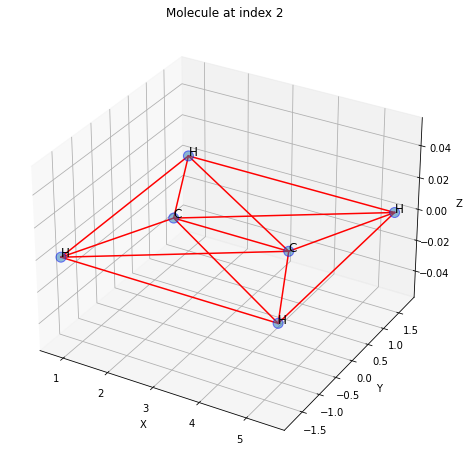

In [251]:
idx = 2
thr = 5
plot_single_molecule(R, Z, idx, thr)

### 2. Data Representation, ML Model and Explanations

**Data Preparation**:
   - Each molecule is represented by summing the one-hot encoded vectors of its constituent atoms.
   - The dataset is centered by subtracting the mean of the features and the target values.

In [257]:
# Atomic number to one-hot vector mapping
#atomic_numbers = [1, 6, 7, 8, 16]
atomic_numbers=np.array(list(atomic_symbols.keys()))
atomic_numbers

array([ 1,  6,  7,  8, 16])

In [267]:
# converting atoms to one-hot vectors and summing one-hot vectors for each molecule
def get_molecule_representation(molecule):
    def one_hot_encode(num_atom):
        one_hot_vector = np.zeros(len(atomic_numbers))
        if num_atom>0:
            #getting the index for atomic element (H, C, N, S, O)
            one_hot_vector[np.where(atomic_numbers==num_atom)] = 1
        return one_hot_vector

    molecule_representation = np.zeros(len(atomic_numbers))
    for atom_number in molecule:
        molecule_representation += one_hot_encode(atom_number)
    return molecule_representation


In [268]:
Z[1]

array([6., 6., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [269]:
#testing for molecule at idx=1
print(get_molecule_representation(Z[1]))

[6. 2. 0. 0. 0.]


In [262]:
X = np.array([get_molecule_representation(Z[i]) for i in range(Z.shape[0])])
y = T

In [263]:
X

array([[ 4.,  1.,  0.,  0.,  0.],
       [ 6.,  2.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  0.,  0.],
       ...,
       [ 9.,  6.,  1.,  0.,  0.],
       [10.,  7.,  0.,  0.,  0.],
       [12.,  7.,  0.,  0.,  0.]])

In [264]:
print(X.shape, y.shape)

(7165, 5) (7165,)


In [265]:
min(y), max(y)

(-2192.0, -404.88)

##### Stratified K-Fold Cross-Validation for Model Selection and Evaluation

In the modelling part, we applied stratified 5-fold cross-validation to ensure that each fold contains a representative set of atomization energies. This technique reduces the variance of the estimator of the test error, providing a more reliable estimate of model performance. The stratification method follows the approach presented in Rupp et al. ([PhysRevLett.108.058301](https://link.aps.org/accepted/10.1103/PhysRevLett.108.058301)), where molecules are grouped into buckets based on their atomization energies, ensuring an even distribution of target values across folds.



This method is particularly important when dealing with datasets where the target variable has a wide range or is imbalanced. By maintaining the distribution of atomization energies across folds, stratified k-fold cross-validation helps to:
- Prevent overfitting
-Avoids overly optimistic error estimates. i.e provide a more accurate and reliable assessment of the model's generalization performance.
- Reduce the variance of the performance estimate.


For stratification, we carried out:
1. **Bucket Creation**: Molecules are splitted into buckets, each containing five molecules, sorted by their atomization energy.   

2. **Stratified Sampling**: The data is split into k folds, and then.  The buckets are then randomly shuffled, and each fold receives one element from each bucket. This ensures that each fold is a representative sample of the overall distribution.

In [218]:
bucket_size=5
sorted_indices = np.argsort(y)
buckets = [sorted_indices[i:i + bucket_size] for i in range(0, len(y), bucket_size)]

In [219]:
len(buckets)

1433

In [220]:
# Stratified K-Fold sampling
# Assigns one molecule from each bucket to each fold, 
#ensuring that each fold contains a representative sample of the overall distribution

def stratified_k_fold(buckets, n_splits=5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    # Initializing empty folds
    folds = [[] for _ in range(n_splits)]
    
    # Distributing one molecule from each bucket to each fold
    for bucket in buckets:
        np.random.shuffle(bucket)  # Shuffling the molecules within each bucket for ensuring randomness
        for i, molecule in enumerate(bucket):
            fold_idx = i % n_splits
            folds[fold_idx].append(molecule)
    
    return folds

**Nested Cross-Validation**

**Outer Loop**

The outer loop of the nested cross-validation procedure is responsible for evaluating the model's performance:

1. **Data Splitting**:
   - The data is split into k=5 stratified folds.
   - In each iteration, one fold is set aside as the test set, and the remaining k-1=4 folds are used for training and validation.

2. **Model Training and Validation**:
   - The training and validation process is carried out within the inner loop (described below) to select the best  lambda.
   - Once the best lambda is determined, a final model is trained on the combined training and validation set using this lambda.

3. **Model Evaluation**:
   - The final model is evaluated on the test set.
   - Performance metrics (RMSE and MAE) are recorded.

This process is repeated for each of the 5 outer folds, ensuring that each fold is used as the test set exactly once.

4. **Performance Metrics Calculation**:
   - The root mean squared error (RMSE) and mean absolute error (MAE) are calculated for each outer fold.
   - The mean and standard deviation of these metrics across all outer folds are reported as the final performance measures. Measures include the average and the variability of the performance metrics (RMSE, MAE) across all outer folds
    
**Inner Loop**

The inner loop is nested within each iteration of the outer loop and is responsible for hyperparameter tuning:

1. **Hyperparameter Candidates**:
   - A range of candidate values for the hyperparameter lambda is defined (using a logarithmic scale from 10^-10 to 10^10).

2. **Inner Data Splitting**:
   - The training+validation data from the outer loop is further split into 4 folds.

3. **Hyperparameter Evaluation**:
   - For each candidate lambda, the model is trained on 3 folds and validated on the remaining fold.
   - This process is repeated 4 times, with each fold being used as the validation set once.
   - The mean absolute error (MAE) is calculated for each validation set and averaged across the 4 folds.


In [230]:
#for inner loop
def select_best_lambda_kfold(X_train_val, y_train_val, lambdas, k):
    best_lambda = None
    best_mae = float('inf')
    lambda_scores = {l: [] for l in lambdas}
    inner_kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    for l in lambdas:
        mae_scores = []

        for train_index, val_index in inner_kf.split(X_train_val):
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            y_train, y_val = y_train_val[train_index], y_train_val[val_index]
            
            mean_X_train=X_train.mean(axis=0)
            X_train=X_train-mean_X_train
            X_val=X_val-mean_X_train
            mean_y_train=y_train.mean()
            y_train=y_train -mean_y_train
            y_val=y_val - mean_y_train
            

            ridge_reg = Ridge(alpha=l)
            ridge_reg.fit(X_train, y_train)
            y_pred_val = ridge_reg.predict(X_val)
            mae_val = mean_absolute_error(y_val, y_pred_val)
            mae_scores.append(mae_val)

        lambda_scores[l].append(np.mean(mae_scores))

    # Select the lambda that performs best in the majority of the inner folds
    best_lambda = min(lambda_scores, key=lambda l: np.mean(lambda_scores[l]))
    best_mae = np.mean(lambda_scores[best_lambda])

    return best_lambda, best_mae

In [231]:
# cross-validation parameters
outer_k = 5
inner_k = outer_k-1
lambdas = np.logspace(-5, 5, 200)
random_state = 42

# Outer loop
outer_folds = stratified_k_fold(buckets, n_splits=outer_k, random_state=random_state)
outer_rmse_scores = []
outer_mae_scores = []

In [232]:
print(len(outer_folds), len(outer_folds[0]))

5 1433


In [233]:
#new
best_lambda_per_fold = []
for fold in outer_folds:
    test_index = np.array(fold)
    train_val_index = np.setdiff1d(np.arange(len(X)), test_index)
    
    X_train_val, X_test = X[train_val_index], X[test_index]
    print(X_train_val.shape, X_test.shape)
    y_train_val, y_test = y[train_val_index], y[test_index]
    

    # Inner loop to select the best lambda
    best_lambda, best_mae = select_best_lambda_kfold(X_train_val, y_train_val, lambdas, 5)
    best_lambda_per_fold.append((best_lambda, best_mae))
    
    # final model with the best lambda on the entire training + validation set
    ridge_reg = Ridge(alpha=best_lambda)
    
    
    mean_X_train_val= X_train_val.mean(axis=0)
    X_train_val=X_train_val-mean_X_train_val
    X_test=X_test-mean_X_train_val
    
    mean_y_train_val=y_train_val.mean()
    y_train_val = y_train_val - mean_y_train_val
    y_test = y_test - mean_y_train_val
    
    ridge_reg.fit(X_train_val, y_train_val)

    #  on the test set valid
    y_pred_test = ridge_reg.predict(X_test)

    #  RMSE and MAE for this outer loop
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    outer_rmse_scores.append(rmse_test)
    outer_mae_scores.append(mae_test)

(5732, 5) (1433, 5)
(5732, 5) (1433, 5)
(5732, 5) (1433, 5)
(5732, 5) (1433, 5)
(5732, 5) (1433, 5)


In [234]:
# Calculating mean and standard deviation of RMSE and MAE across outer folds
mean_rmse = np.mean(outer_rmse_scores)
std_rmse = np.std(outer_rmse_scores)
mean_mae = np.mean(outer_mae_scores)
std_mae = np.std(outer_mae_scores)

print(f"RMSE on Test Set: {mean_rmse:.2f} ± {std_rmse:.2f}")
print(f"MAE on Test Set: {mean_mae:.2f} ± {std_mae:.2f}")


RMSE on Test Set: 20.18 ± 0.39
MAE on Test Set: 15.70 ± 0.13


In [235]:
outer_rmse_scores

[19.91069370322136,
 20.326067897863,
 20.82726746304304,
 20.165192518440772,
 19.676315184973127]

In [236]:
outer_mae_scores

[15.55120415552206,
 15.787383144675783,
 15.879296416292712,
 15.737314651221059,
 15.550504946064537]

In [110]:
# Final model training on the entire dataset using the best lambda
#final_best_lambda = np.mean(best_lambdas)
#ridge_reg_final = Ridge(alpha=final_best_lambda)
#ridge_reg_final.fit(X_cent, y_cent)

In [111]:
#  final weight coefficients
#w = ridge_reg_final.coef_
#print(f"Final weight coefficients: {w}")

In [112]:
best_lambda_final = best_lambda_per_fold[np.argmin(outer_rmse_scores)][0]

In [113]:
best_lambda_final

1e-05

In [114]:
# Final model training on the entire dataset using the best lambda
ridge_reg_final = Ridge(alpha=best_lambda_final)
ridge_reg_final.fit(X_cent, y_cent)
w = ridge_reg_final.coef_
print(f"Final weight coefficients: {w}")

Final weight coefficients: [ -68.75672598 -157.49050258 -102.55968775 -101.45620621  -80.49403017]


### XAI on Simple atom-based model

In [115]:
#change it molecule based explanation
def explain_prediction(molecule_idx, w):
    #getting the feature vector representation for molecule at idx
    molecule_representation = get_molecule_representation(Z[molecule_idx])
    explanations = {}
    for i, atom_type in enumerate(atomic_numbers):
        contribution = w[i] * molecule_representation[i]
        explanations[atom_type] = contribution
    return explanations


In [116]:
def plot_contributions(idx, explanations, atomic_symbols):
    atom_labels = [atomic_symbols[atom_type] for atom_type in atomic_numbers]
    contributions = [explanations[atom_type] for atom_type in atomic_numbers]

    plt.figure(figsize=(10, 6))
    plt.barh(atom_labels, contributions, color='red')
    plt.xlabel('Contribution to Atomization Energy')
    plt.ylabel('Atom Type')
    plt.title(f'Contributions of Each Atom Type to Predicted Atomization Energy of Molecule {idx}')
    plt.show()

In [117]:
molecule_idx = 30 
explanations = explain_prediction(molecule_idx, w)
explanations

{1: -481.29708183921736,
 6: -472.47150774261513,
 7: -102.55968774970279,
 8: -0.0,
 16: -0.0}

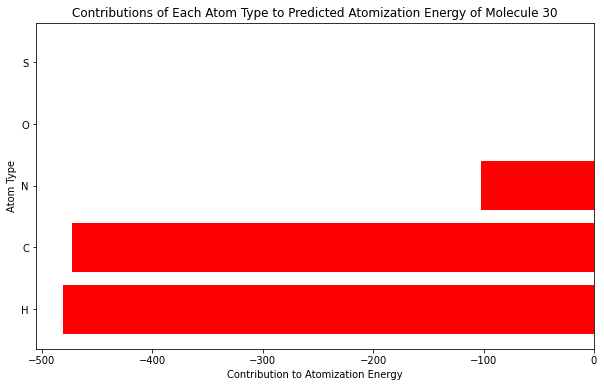

In [118]:
# Plot the contributions
plot_contributions(molecule_idx, explanations, atomic_symbols)

Ref to use: The negative contributions can be interpreted as the atoms' tendency to stabilize the molecule. When atoms form bonds, they achieve a lower energy state compared to when they are free. The more negative the contribution, the more the atom helps in stabilizing the molecule.

In [119]:
def explain_prediction_normalized(molecule_idx, w):
    molecule_representation = get_molecule_representation(Z[molecule_idx])
    explanations = {}
    total_contribution = np.sum(w * molecule_representation)
    for i, atom_type in enumerate(atomic_numbers):
        contribution = w[i] * molecule_representation[i]
        normalized_contribution = contribution / total_contribution
        explanations[atom_type] = normalized_contribution
    return explanations

In [120]:
molecule_idx = 30 
explanations = explain_prediction_normalized(molecule_idx, w)
explanations

{1: 0.45563210998673215,
 6: 0.4472771560524333,
 7: 0.09709073396083459,
 8: 0.0,
 16: 0.0}

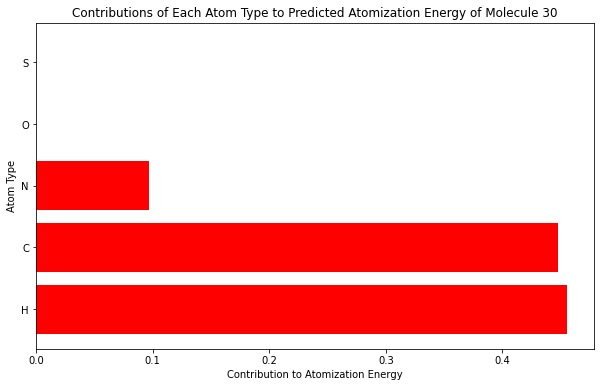

In [121]:
# Plot the normalized contributions
plot_contributions(molecule_idx, explanations, atomic_symbols)

### Decomposition in terms of pairs of atoms 

Considering mutual distance between atoms, we need to find bin range first.

In [53]:
def distance_range(R, Z):
    distances = []
    for i in range(len(R)):
        coordinates = R[i]
        atomic_numbers = Z[i]
        filtered_coordinates = coordinates[atomic_numbers > 0]  # Filtering out non-existent atoms
        
        # Calculatingg the distance matrix for the filtered coordinates
        dist_matrix = distance_matrix(filtered_coordinates, filtered_coordinates)
        
        # Extracting the upper triangular part of the distance matrix
        #to avoid redundant calculations and exclude the diagonal.
        dist_upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        distances.extend(dist_upper_tri) #concatenatin elements
        
    return np.array(distances)

In [54]:
pair_distances = distance_range(R, Z)

# Finding the min and max distances
min_dist, max_dist = np.min(pair_distances), np.max(pair_distances)
print(f"Min distance: {min_dist}, Max distance: {max_dist}")

Min distance: 1.8265360620743547, Max distance: 18.717450675317142


In [55]:
np.histogram(pair_distances, bins=10)

(array([140953, 238829, 177772, 142337,  78529,  30987,  11923,   2778,
           641,     34]),
 array([ 1.82653606,  3.51562752,  5.20471898,  6.89381045,  8.58290191,
        10.27199337, 11.96108483, 13.65017629, 15.33926775, 17.02835921,
        18.71745068]))

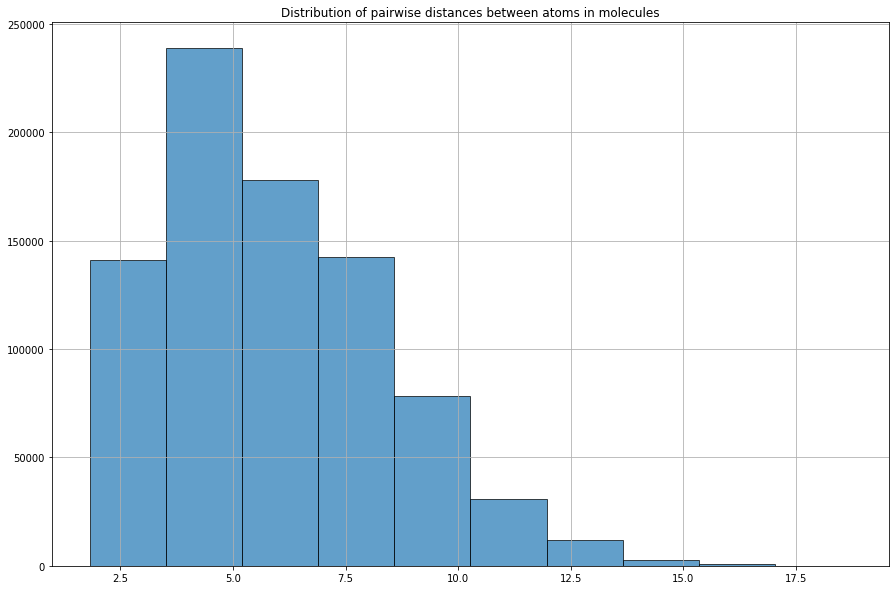

In [56]:
plt.figure(figsize=(15, 10))
plt.hist(pair_distances, bins=10, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of pairwise distances between atoms in molecules')
plt.grid(True)
plt.show()

In [57]:
#dividing distance into 10 bins
distance_bins = np.linspace(min_dist, max_dist, 11)
print(f"Distance bins: {distance_bins}")

Distance bins: [ 1.82653606  3.51562752  5.20471898  6.89381045  8.58290191 10.27199337
 11.96108483 13.65017629 15.33926775 17.02835921 18.71745068]


In [58]:
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

In [59]:
bin_centers

array([ 2.67108179,  4.36017325,  6.04926472,  7.73835618,  9.42744764,
       11.1165391 , 12.80563056, 14.49472202, 16.18381348, 17.87290494])

### Distance feature map for pairs

In [60]:
#hard indicator function
def distance_fmap_hard(distance ,distance_bins):
    num_bins=len(distance_bins)-1
    features = np.zeros(num_bins)
    for i in range(num_bins):
        if distance_bins[i] <= distance < distance_bins[i + 1]:
            features[i] = 1
            break
    return features

In [61]:
d=distance_fmap_hard(10, distance_bins)
d

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [62]:
#soft indicator
def distance_fmap_soft(distance, bin_centers, sigma):
    def gaussian(x, mu, sigma):
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    features = np.array([gaussian(distance, mu, sigma) for mu in bin_centers])
    return features

In [63]:
distance_fmap_soft(10, bin_centers, 1)

array([2.16950726e-12, 1.23896058e-07, 4.08036207e-04, 7.74969738e-02,
       8.48820022e-01, 5.36156180e-01, 1.95304319e-02, 4.10277034e-05,
       4.97035486e-09, 3.47250129e-14])

In [64]:
distance_fmap_soft(10, bin_centers, 3)

array([0.05058714, 0.17082914, 0.42015638, 0.75263982, 0.98195282,
       0.93308511, 0.64577183, 0.32550985, 0.11950233, 0.03195331])

# Atom types pair representation

In [124]:
atomic_numbers

[1, 6, 7, 8, 16]

In [125]:
unique_pairs = [(atomic_numbers[i], atomic_numbers[j]) for i in range(len(atomic_numbers)) for j in range(i, len(atomic_numbers))]

In [126]:
unique_pairs

[(1, 1),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 16),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 16),
 (7, 7),
 (7, 8),
 (7, 16),
 (8, 8),
 (8, 16),
 (16, 16)]

In [127]:
len(unique_pairs)

15

In [128]:
def atom_type_fmap(an1, an2, unique_pairs):
    feature = np.zeros(len(unique_pairs))
    pair = (min(an1, an2), max(an1, an2)) 
    if pair in unique_pairs:
        idx = unique_pairs.index(pair)
        feature[idx] = 1
    return feature

In [129]:
#Testing of atom type feature map for some possible pairs
test_pairs = [
    (1, 1),  # H-H
    (1, 6),  # H-C
    (1, 7),  # H-N
    (1, 8),  # H-O
    (1, 16), # H-S
    (6, 6),  # C-C
    (6, 7),  # C-N
    (7, 8),  # N-O
    (8, 16), # O-S
    (16, 16) # S-S
]

for an1, an2 in test_pairs:
    feature_vector = atom_type_fmap(an1, an2, unique_pairs)
    print(f"Pair ({an1}, {an2}):", feature_vector)
    print("Shape:", feature_vector.shape)
    print("Index of 1 in feature vector:", np.where(feature_vector == 1)[0])
    print()


Pair (1, 1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [0]

Pair (1, 6): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [1]

Pair (1, 7): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [2]

Pair (1, 8): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [3]

Pair (1, 16): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [4]

Pair (6, 6): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [5]

Pair (6, 7): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [6]

Pair (7, 8): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Shape: (15,)
Index of 1 in feature vector: [10]

Pair (8, 16): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Shape: (15,)
Index of 1 in feature vector: [13]

Pair (16, 16): [0. 0. 0.

In [130]:
def get_molecule_representation_pairs(r, z, bin_centers,sigma,  unique_pairs):
    molecule_representation = []
    
    for i in range(len(z)):
        for j in range(i + 1, len(z)):
            if z[i] > 0 and z[j] > 0:  # both positions have valid atoms
                distance = np.linalg.norm(r[i] - r[j])
                dist_fmap = distance_fmap_soft(distance, bin_centers, sigma)
                a_type_fmap = atom_type_fmap(z[i], z[j], unique_pairs)
                
                #big feature map as outer product of 2 f-maps
                combined_fmap = np.outer(dist_fmap, a_type_fmap).flatten()
                molecule_representation.append(combined_fmap)
    
    #if len(molecule_representation) > 0:
    return np.sum(molecule_representation, axis=0)
    #else:
        #return np.zeros(len(bin_centers) * len(unique_pairs))

In [131]:
#test of function   -- need to be DELETED
r=R[7]
z=Z[7]
n_atom_types=len(atomic_numbers)
num_atoms = len(z)
molecule_representation = []
sigma=1

for i in range(num_atoms):
    for j in range(i + 1, num_atoms):
        if z[i] > 0 and z[j] > 0:  # both positions have valid atoms
            distance = np.linalg.norm(r[i] - r[j]) #distances between n valid (nonzero atoms) n*(n-1) pair distances
            #print(distance)
            dist_feature = distance_fmap_soft(distance, bin_centers, sigma)
            #print(len(dist_feature))
            a_type_feature = atom_type_fmap(z[i], z[j], unique_pairs)
            #print(len(a_type_feature))
            combined = np.outer(dist_feature, a_type_feature).flatten()
            #print(combined.shape)
            molecule_representation.append(combined)

if len(molecule_representation) > 0:
    print(np.sum(molecule_representation, axis=0))


[1.73517654e+00 7.63727016e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.51987634e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.43862456e+00
 9.91420128e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.90480810e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.84226334e+00 1.25728166e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.64093687e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.05205376e+01 1.03237766e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.54257920e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.02207714e+01 4.40135853e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.162392

In [132]:
# Determination of the optimal lambda 
def select_best_lambda(X_train, y_train, X_val, y_val, lambdas):
    best_lambda = None
    best_mae = float('inf')
    for l in lambdas:
        ridge_reg = Ridge(alpha=l) #in sklearn Ridge parameter is called alpha
        ridge_reg.fit(X_train, y_train)
        y_pred_val = ridge_reg.predict(X_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        
        if mae_val < best_mae:
            best_mae = mae_val
            best_lambda = l
            
    return best_lambda, best_mae

In [133]:
def evaluate_model(X, y, lambdas):
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean()

    #80-10-10
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_centered, y_centered, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  
    
    #determining best lambda
    best_lambda,_=select_best_lambda(X_train, y_train, X_val, y_val, lambdas)

    #building model with best lambda and eval on test set
    ridge_reg = Ridge(alpha=best_lambda)
    ridge_reg.fit(X_train_val, y_train_val)
    y_pred_test = ridge_reg.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    return mae_test, best_lambda

### Determination of best number of bins, sigma value, lamda 

In [391]:
#  grid search 
num_bins = [5, 10, 20]
sigmas = [0.5, 1.0, 2.0]
lambdas = np.logspace(-5, 5, 50)

best_params = None
best_mae = float('inf')

for num_bins in num_bins:
    for sigma in sigmas:
        distance_bins = np.linspace(min_dist,max_dist, num_bins + 1)
        bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2
        X = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, sigma, unique_pairs) for i in range(Z.shape[0])])
        y = T
        
        mae_test, best_lambda = evaluate_model(X, y, lambdas)
        
        if mae_test < best_mae:
            best_mae = mae_test
            best_params = (num_bins, sigma, best_lambda)

print(f"Best parameters: num_bins = {best_params[0]}, sigma = {best_params[1]}, lambda = {best_params[2]}")
print(f"Best MAE on test set: {best_mae}")

Best parameters: num_bins = 20, sigma = 0.5, lambda = 0.7906043210907702
Best MAE on test set: 6.067873406980688


In [394]:
#retriving best parameter values for final model 
best_num_bins = best_params[0]
best_sigma = best_params[1]
best_lambda = best_params[2]

In [395]:
# Recomputing distance bins and bin centers with best size of intervals (number of bins)
distance_bins = np.linspace(min_dist,max_dist, best_num_bins + 1)
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

In [397]:
X2 = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, best_sigma, unique_pairs) for i in range(Z.shape[0])])
y2 = T

In [398]:
X_cent2 = X2 -X2.mean(axis=0)
y_cent2 = y2 - y2.mean()

X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(X_cent2, y_cent2, test_size=0.2, random_state=42)

In [399]:
print(f"Train+val size:\t{X_train_val2.shape[0]:>5}")
print(f"Test size:\t{X_test2.shape[0]:>5}")

Train+val size:	 5732
Test size:	 1433


In [404]:
#the final model using the best lambda
final_model = Ridge(alpha=best_lambda)
final_model.fit(X_train_val2, y_train_val2)


y_pred_test2= final_model.predict(X_test2)
mae_test = mean_absolute_error(y_test2, y_pred_test2)
print(f"Mean Absolute Error on Test Set: {mae_test:.2f}")

Mean Absolute Error on Test Set: 6.07


In [401]:
# weights in the original space (before centering)
w2 = final_model.coef_
b2 = y.mean() - np.dot(w2, X2.mean(axis=0))

print(f"Final Model Weights: {w2}")
print(f"Final Model Intercept: {b2}")

Final Model Weights: [-7.59962896e-01 -9.19973152e+01 -8.90160587e+01 -9.71562185e+01
 -1.54320853e-02 -6.27793319e+01 -4.87549126e+01 -4.38379409e+01
 -2.12080553e+01 -1.94218508e+00 -6.17907639e+00 -8.06027367e+00
  2.39839313e-02  1.60117377e+01  0.00000000e+00  1.14245522e+00
  3.79811426e+00  2.72707280e+00  8.53249444e+00 -1.01028141e+00
 -8.18378427e+00  1.06308375e+01  1.22546910e+01 -3.43413004e+01
  2.79987950e+01  4.34608404e+01 -6.79511753e+00  1.72645217e+00
 -4.96164768e+00  0.00000000e+00  5.38793719e-02 -2.43969937e-01
  9.11291599e-01  3.87322069e-02 -3.20097063e+00 -1.98254399e+01
 -2.38830041e+01 -2.11013306e+01  9.51631048e+00 -2.51023442e+01
 -3.29792701e+01 -5.48837071e+00 -2.70783416e+01 -6.36101213e+00
  0.00000000e+00 -1.36721064e+00  8.30274798e-01  6.30985151e-01
  2.28823292e-01  3.09750960e+00 -1.70662830e+01 -1.40792189e+01
 -1.25181501e+01 -1.54611743e+01 -1.59777787e+00 -6.64276464e+00
 -1.44372938e+01 -1.28574031e+01 -1.01805754e+00  0.00000000e+00
  8.

In [406]:
w2.shape #15 pairs * 20 distance bins

(300,)

In [140]:
# params
num_bins = [5, 10, 20]
sigmas = [0.5, 1.0, 2.0]
lambdas = np.logspace(-5, 5, 50)

In [136]:
outer_kf = KFold(n_splits=k, shuffle=True, random_state=42)
outer_rmse_scores = []
outer_mae_scores = []
best_params_per_fold = []

for train_val_index, test_index in outer_kf.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

    inner_kf = KFold(n_splits=k-1, shuffle=True, random_state=42)
    best_params = None
    best_mae = float('inf')

    for num_bin in num_bins:
        distance_bins = np.linspace(min_dist, max_dist, num_bin + 1)
        bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

        for sigma in sigmas:
            X_train_pairs = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, sigma, unique_pairs) for i in train_val_index])
            X_test_pairs = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, sigma, unique_pairs) for i in test_index])

            best_lambda, _ = select_best_lambda_kfold(X_train_pairs, y_train_val, lambdas, k-1)

            ridge_reg = Ridge(alpha=best_lambda)
            ridge_reg.fit(X_train_pairs, y_train_val)
            y_pred_test = ridge_reg.predict(X_test_pairs)

            rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
            mae_test = mean_absolute_error(y_test, y_pred_test)

            if mae_test < best_mae:
                best_mae = mae_test
                best_params = (num_bin, sigma, best_lambda)

    best_params_per_fold.append(best_params)
    outer_rmse_scores.append(rmse_test)
    outer_mae_scores.append(mae_test)

mean_rmse = np.mean(outer_rmse_scores)
std_rmse = np.std(outer_rmse_scores)
mean_mae = np.mean(outer_mae_scores)
std_mae = np.std(outer_mae_scores)

print(f"RMSE on Test Set: {mean_rmse:.2f} ± {std_rmse:.2f}")
print(f"MAE on Test Set: {mean_mae:.2f} ± {std_mae:.2f}")


### Pairwise Potentials

In [ ]:
# Function to plot pairwise potentials
def plot_pairwise_potentials(w, unique_pairs, bin_centers, atomic_symbols):
    num_bins = len(bin_centers)
    
    #for each pair plotting the contribution vs distance
    for i, pair in enumerate(unique_pairs):
        
        #extarcting the weights (contributions) for the current pair 
        contributions = w2[i*num_bins:(i+1)*num_bins] 
        
        plt.figure(figsize=(12, 8))
        plt.plot(bin_centers, contributions, marker='o')
        plt.xlabel('Distance')
        plt.ylabel('Contribution to Atomization Energy')
        plt.title(f'Pairwise Potentials for {atomic_symbols[pair[0]]}-{atomic_symbols[pair[1]]}')
        
        plt.grid(True)
        plt.show()

In [ ]:
# Plot pairwise potentials for each unique pair
plot_pairwise_potentials(w, unique_pairs, bin_centers, atomic_symbols)

#need to understand from this plot.<br>
Make these plots, and check whether the pairwise potentials you obtain for each
pair of atom types are consistent with chemical knowledge, e.g. whether they reflect typical bond lengths
between different atoms.

typical bond lengths in Ångströms (Å):

H-H: ~0.74 Å

C-H: ~1.09 Å

C-C: ~1.54 Å (single bond), ~1.34 Å (double bond), ~1.20 Å (triple bond)

N-H: ~1.01 Å

N-N: ~1.45 Å (single bond), ~1.25 Å (double bond)

O-H: ~0.96 Å

O-O: ~1.48 Å (single bond), ~1.21 Å (double bond)

S-H: ~1.34 Å

S-S: ~2.05 Å (single bond)
